In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import time

# Reddit API Configuration
REDDIT_CLIENT_ID = "Ypp6I83c39fhojfQsnVBDg"
REDDIT_CLIENT_SECRET = "c8--JDpX41fgMWHO1CUJHf5KBWz6EA"
REDDIT_USER_AGENT = "Stock News Scraper (by Kindly_Cut3556)"

SUBREDDITS = [
    # Indian Focus
    "IndianStockMarket", "DalalStreetTalks", "IndiaInvestments",
    "NSEbets", "IndianStreetBets", "IndiaTax", "Mumbai",
    "Bengaluru", "Delhi", "Chennai", "Hyderabad",

    # Global Financial Hubs
    "stocks", "investing", "StockMarket", "Finance",
    "EconomicIndicators", "ValueInvesting", "Daytrading",
    "WallStreetBets", "SmallStreetBets", "RobinHood",

    # Sector-Specific
    "Telecom", "RenewableEnergy", "Oil", "Retail",
    "SupplyChain", "5G", "TechNews", "Ecommerce",

    # Regional Markets
    "AsiaInvesting", "EmergingMarkets", "SingaporeStocks",
    "DubaiStocks", "LondonStockExchange",

    # News Aggregators
    "worldnews", "business", "Economics", "GlobalMarkets",
    "Geopolitics", "CryptoCurrency", "Commodities"
]
KEYWORDS = [
    # Reliance-Specific
    "Reliance", "RIL", "Mukesh Ambani", "Nita Ambani",
    "Reliance Jio", "Jio Platforms", "JioMart",
    "Reliance Retail", "Reliance Digital",
    "Reliance Petroleum", "Reliance AGM", "Reliance O2C",
    "Reliance Green Energy", "Jio Financial Services",

    # Stock Market Terms
    "Nifty 50", "Sensex", "BSE", "NSE", "Nifty Bank",
    "Nifty IT", "Nifty Pharma", "Nifty FMCG", "Nifty Metal",
    "F&O", "SIP", "Mutual Funds", "IPO", "Dividend",

    # Economic Indicators
    "GDP India", "Inflation India", "RBI Policy",
    "GST India", "FDI India", "Trade Deficit", "Rupee",
    "Current Account Deficit", "Fiscal Policy",

    # Sector Keywords
    "Telecom Sector", "5G Rollout", "Green Hydrogen",
    "Oil Refining", "Polyester", "Petrochemicals",
    "Organized Retail", "E-commerce Growth",

    # Competitors/Comparisons
    "Tata Group", "Adani Group", "Airtel", "Vodafone Idea",
    "Amazon India", "Flipkart", "DMart", "Nykaa",

    # Hashtags/Abbreviations
    "#RIL", "#Nifty50", "#Sensex", "#BSE", "#NSE",
    "$RELIANCE.NS", "$NSEI", "$BSESN"
]
START_DATE = datetime(2023, 6, 1)
END_DATE = datetime.now()

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)

def fetch_reddit_posts():
    news_items = []

    for subreddit_name in SUBREDDITS:
        print(f"Searching in r/{subreddit_name}...")
        try:
            subreddit = reddit.subreddit(subreddit_name)

            # Method 1: Search with multiple time filters
            for time_filter in ["year", "month", "week", "all"]:
                results = subreddit.search(
                    query=" OR ".join(KEYWORDS),
                    sort="relevance",
                    time_filter=time_filter,
                    limit=1000  # Max allowed
                )
                for submission in results:
                    process_submission(submission, news_items)
                time.sleep(2)

            # Method 2: Get top posts from different categories
            for category in ["hot", "top", "new"]:
                submissions = getattr(subreddit, category)(limit=1000)
                for submission in submissions:
                    if any(kw.lower() in submission.title.lower() for kw in KEYWORDS):
                        process_submission(submission, news_items)

                time.sleep(2)

        except Exception as e:
            print(f"Error in r/{subreddit_name}: {str(e)}")
            continue

    return news_items

def process_submission(submission, news_items):
    try:
        post_date = datetime.utcfromtimestamp(submission.created_utc)
        if START_DATE <= post_date <= END_DATE:
            # Get top 5 comments
            try:
                submission.comments.replace_more(limit=5)  # Load more comments
                comments = [comment.body for comment in submission.comments.list()[:5]]
            except Exception as comment_error:
                print(f"Error getting comments: {comment_error}")
                comments = []

            time.sleep(0.5)  # Rate limiting

            news_items.append({
                "date": post_date.strftime("%Y-%m-%d"),
                "title": submission.title,
                "score": submission.score,
                "url": submission.url,
                "subreddit": submission.subreddit.display_name,
                "post_comments": comments
            })
    except Exception as e:
        print(f"Error processing submission: {str(e)}")

# Fetch all posts
print("Starting data collection...")
all_posts = fetch_reddit_posts()

# Create DataFrame
df = pd.DataFrame(all_posts)

# Deduplicate posts
df = df.drop_duplicates(subset=["title", "date"])

# Process and group by date
df["date"] = pd.to_datetime(df["date"])
daily_news = df.groupby("date").apply(
    lambda x: x.sort_values("score", ascending=False).head(5)["title"].tolist()
)
daily_news = df.groupby("date").apply(
    lambda x: {
        "titles": x.nlargest(5, "score")["title"].tolist(),
        "comments": x.nlargest(5, "score")["post_comments"].tolist()
    }
)

final_df2 = pd.DataFrame({
    "date": daily_news.index,
    "news": daily_news.apply(lambda x: x["titles"]),
    "top_comments": daily_news.apply(lambda x: x["comments"])
})
# Create final DataFrame
# final_df = pd.DataFrame({
#     "date": daily_news.index,
#     "news": daily_news.values
# }).sort_values("date")

# Save to CSV
# final_df2.to_csv("enhanced_reddit_finance_news7.csv", index=False)
# print(f"Saved {len(final_df2)} days of data")

In [ ]:
dt=final_df

In [1]:
import numpy as np
import pandas as pd

In [4]:
import ast
import pandas as pd

# Suppose your DataFrame is called df, with columns 'news' and 'top_comments',
# each containing a string that looks like a Python list.

# For safety, define a small parsing function that returns the original string
# if parsing fails, or returns None if it's empty.
def parse_list_str(s):
    # Check if the value is a string or bytes before attempting to parse
    if isinstance(s, (str, bytes)):
        if pd.isnull(s):
            return None  # or return []
        try:
            return ast.literal_eval(s)
        except (SyntaxError, ValueError):
            # If it's not valid Python syntax, handle it however you like
            return s
    # If it's not a string or bytes, and not NaN, return it as is
    elif not pd.isnull(s) and not isinstance(s, type(np.nan)):  # Check for np.nan too
        return s
    else:
        return None  # or []


# Apply the parser to each column
dt["news"] = dt["news"].apply(parse_list_str)
dt["top_comments"] = dt["top_comments"].apply(parse_list_str)
def flatten_top_comments(comments):
    """
    If `comments` is a list containing exactly one inner list,
    return that inner list. Otherwise, return `comments` unchanged.
    """
    if comments and len(comments) == 1 and isinstance(comments[0], list):
        return comments[0]
    return comments

# Suppose your DataFrame is called df, and "top_comments" is the column
dt["top_comments"] = dt["top_comments"].apply(flatten_top_comments)
dt['news'] = dt['news'].apply(
    lambda x: x[0].split(', ', 1) if x and ', ' in x[0] else x
)
import spacy

# Load spaCy's English model (install with: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    """
    Lemmatizes the input text using spaCy.
    If the input is a list, each element is processed individually and
    the original structure is preserved.
    Otherwise, returns a single lemmatized string.
    """
    if isinstance(text, list):
        # If it's a list, lemmatize each string in the list.
        return [lemmatize_text(item) for item in text]
    else:
        doc = nlp(str(text))
        return " ".join(token.lemma_ for token in doc)

# Example usage with your DataFrame 'dt'
# Assuming dt['news'] and dt['top_comments'] are columns with list values like ['a','b']
dt['news_lemmatized'] = dt['news'].apply(lemmatize_text)
dt['top_comments_lemmatized'] = dt['top_comments'].apply(lemmatize_text)
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
combined_stopwords = nltk_stopwords.union(sklearn_stopwords)

def tweet_cleaner_without_lemmatization(text):
    """
    Cleans the input text by removing contractions, hashtags, mentions, URLs,
    non-alphabetical characters, converting to lowercase, and removing extra whitespace.
    It also removes words that appear in combined_stopwords.

    If the input is a list, the function processes each element individually,
    preserving the list structure.
    """
    if isinstance(text, list):
        # Process each item in the list recursively
        return [tweet_cleaner_without_lemmatization(item) for item in text]

    # Remove "'s" contractions
    new_text = re.sub(r"'s\b", " is", text)
    # Remove hashtags and user mentions
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    # Remove URLs
    new_text = re.sub(r"http\S+", "", new_text)
    # Expand contractions (e.g., "can't" -> "cannot")
    new_text = contractions.fix(new_text)
    # Remove non-alphabet characters
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    # Convert to lowercase and strip extra whitespace
    new_text = new_text.lower().strip()

    # Remove stopwords from the cleaned text.
    tokens = new_text.split()
    tokens_without_stopwords = [word for word in tokens if word not in combined_stopwords]
    cleaned_text = " ".join(tokens_without_stopwords)

    return cleaned_text
dt['news_lemmatized_cleaned'] = dt['news_lemmatized'].apply(tweet_cleaner_without_lemmatization)
dt['top_comments_lemmatized_cleaned'] = dt['top_comments_lemmatized'].apply(tweet_cleaner_without_lemmatization)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_sentiment_score(text):
    """
    Uses FinBERT tone to obtain a sentiment score between -1 and 1.
    We map the probabilities as follows:
       - For 'positive': mapped_score = 2 * probability - 1
       - For 'neutral': mapped_score = 0.0
       - For 'negative': mapped_score = 1 - 2 * probability
    This mapping sets 0.5 probability to neutral (0) and scales accordingly.
    """
    if not isinstance(text, str):
        return 0.0  # Return 0 if input is not a string

    # Truncate the text if too long (here, using character truncation; you might wish to use a tokenizer for token count)
    text = text[:512]

    # If text is empty, return 0.
    if not text.strip():
        return 0.0

    result = sentiment_pipeline(text)[0]
    prob = result.get('score', 0.0)
    label = result.get('label', '').lower()

    if label == 'positive':
        mapped_score = 2 * prob - 1
    elif label == 'neutral':
        mapped_score = 0.0
    elif label == 'negative':
        mapped_score = 1 - 2 * prob
    else:
        mapped_score = 0.0
    return mapped_score

def average_sentiment(text_list):
    """
    Applies get_sentiment_score to each string in a list (or nested list) and returns the average score.
    """
    if not text_list:
        return 0.0

    # If it's a single string, process directly.
    if isinstance(text_list, str):
        return get_sentiment_score(text_list)

    # If it's a list, recursively process each element.
    elif isinstance(text_list, list):
        scores = [average_sentiment(item) for item in text_list if item]
        return sum(scores) / len(scores) if scores else 0.0

    return 0.0
dt['news_sentiment'] = dt['news_lemmatized_cleaned'].apply(average_sentiment)
dt['comments_sentiment'] = dt['top_comments_lemmatized_cleaned'].apply(average_sentiment)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


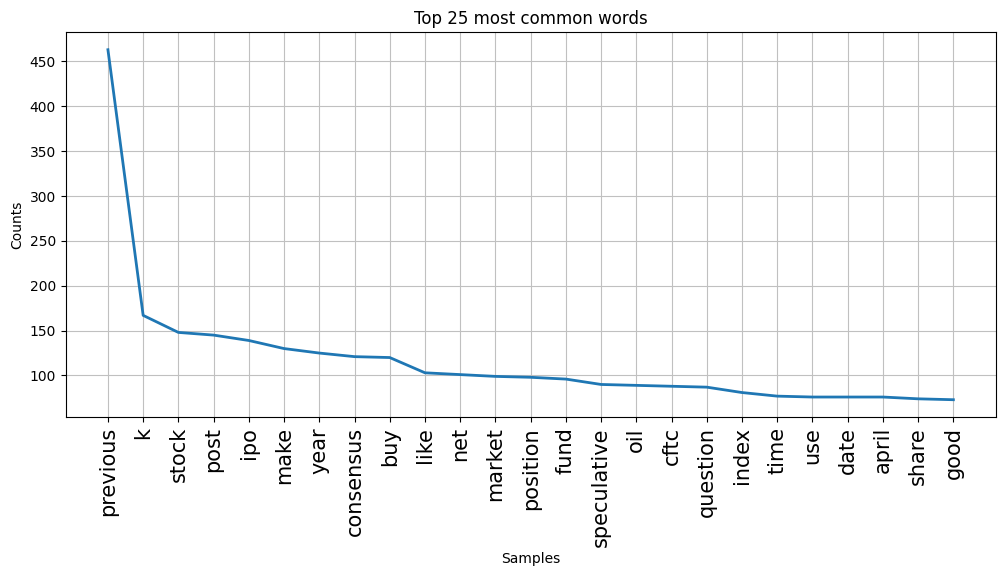

In [10]:
all_words = []
for t in dt['top_comments_lemmatized_cleaned']:
    if isinstance(t, str):  # Check if t is a string
        all_words.extend(t.split())
    elif isinstance(t, list):  # Check if t is a list
        for item in t:
            if isinstance(item, str):  # Check if item in list is a string
                all_words.extend(item.split())
for t in dt['news_lemmatized_cleaned']:
    if isinstance(t, str):  # Check if t is a string
        all_words.extend(t.split())
    elif isinstance(t, list):  # Check if t is a list
        for item in t:
            if isinstance(item, str):  # Check if item in list is a string
                all_words.extend(item.split())
import matplotlib.pyplot as plt
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

In [ ]:
date_range = pd.date_range(start="2023-06-01", end="2025-03-03", freq="D")

# Create DataFrame
dt2 = pd.DataFrame({"date": date_range})
dt['date'] = pd.to_datetime(dt['date'])
dt2 = dt2.merge(dt, on="date", how="left").fillna(0)
dt2=dt2[['date','news_sentiment','comments_sentiment']]
dt2 = dt2.sort_values(by='date')  # Sort by date

# Define weights for the last 5 days
weights = [40, 25, 15, 10, 10]  # Adjust as needed
weights = [w / sum(weights) for w in weights]  # Normalize weights to sum to 1

def weighted_sentiment(series):
    return (
        series.shift(1) * weights[0] +
        series.shift(2) * weights[1] +
        series.shift(3) * weights[2] +
        series.shift(4) * weights[3] +
        series.shift(5) * weights[4]
    ).fillna(0)  # Fill missing values with 0 for early rows

# Apply weighted sum for the previous 5 days
dt2['comments_sentiment_weighted'] = weighted_sentiment(dt2['comments_sentiment'])
dt2['news_sentiment_weighted'] = weighted_sentiment(dt2['news_sentiment'])
dt2['weighted_sentiment'] = dt2['comments_sentiment_weighted']*0.5 + dt2['news_sentiment_weighted']*0.5

In [13]:
dt2=dt2[['date','weighted_sentiment']]

In [14]:
dt2.to_csv('dt.csv',index=False)